      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
mean       8.311111          0.531339     0.268364        2.532152   0.086933   
std        1.747595          0.179633     0.196686        1.355917   0.047267   
min        4.600000          0.120000     0.000000        0.900000   0.012000   
max       15.900000          1.580000     1.000000       15.500000   0.611000   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
mean            15.615486             45.914698  0.996730  3.311015   
std             10.250486             32.782130  0.001925  0.156664   
min              1.000000              6.000000  0.990070  2.740000   
max             68.000000            289.000000  1.003690  4.010000   

      sulphates    alcohol   quality  
mean   0.657708  10.442111  5.657043  
std    0.170399   1.082196  0.805824  
min    0.330000   8.400000  3.000000  
max    2.000000  14.900000  8.000000  


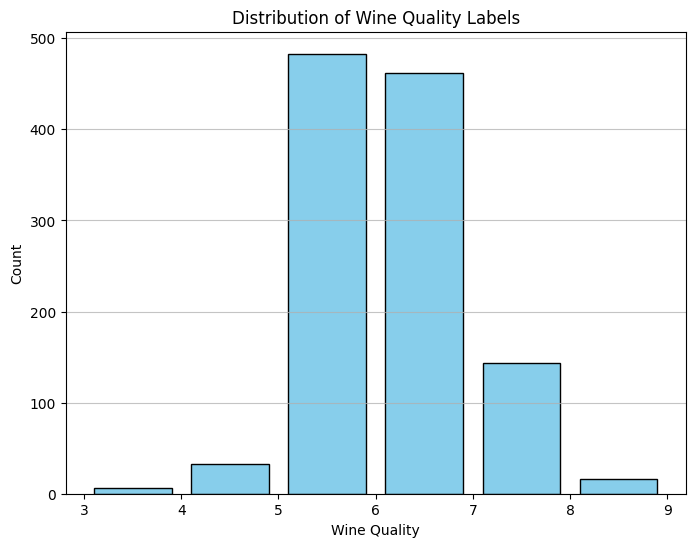

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

#-------Load the dataset and Print the statistics-------------
wine_data = pd.read_csv("WineQT.csv")
wine_data = wine_data.drop(columns=['Id'])
statistics = wine_data.agg(['mean', 'std', 'min', 'max'])
print(statistics)

#---a graph that shows the distribution of the various labels across the entire dataset----
wine_quality = wine_data['quality']

plt.figure(figsize=(8, 6))
plt.hist(wine_quality, bins=range(3, 10), rwidth=0.8, color='skyblue', edgecolor='black')
plt.xlabel('Wine Quality')
plt.ylabel('Count')
plt.title('Distribution of Wine Quality Labels')
plt.xticks(range(3, 10))
plt.grid(axis='y', alpha=0.75)
plt.show()

#---------Split the data into train (70%), validation (15%), and test (15%) sets--------
X = wine_data.drop(columns=['quality'])
y = wine_data['quality']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#-------------------Normalise and standarize the data------------------
# Handle missing data (if any)
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

# Standardize the data (mean=0, std=1) using Z-score scaling
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_val_standardized = scaler.transform(X_val)
X_test_standardized = scaler.transform(X_test)



In [6]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

class MultinomialLogisticRegression:
    def __init__(self, num_classes, learning_rate=0.001, max_iterations=30000):
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.weights = None
        self.bias = None

    def softmax(self, z):
        # Softmax function to calculate class probabilities
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def one_hot_encode(self, y):
        # Convert class labels to one-hot encoding
        one_hot = np.zeros((len(y), self.num_classes))
        one_hot[np.arange(len(y)), y-3] = 1
        return one_hot

    def initialize_parameters(self, num_features):
        # Initialize weights and bias
        self.weights = np.random.randn(num_features, self.num_classes)
        self.bias = np.zeros((1, self.num_classes))

    def compute_loss(self, y_true, y_pred):
        # Cross-entropy loss
        m = len(y_true)
        loss = -1/m * np.sum(y_true * np.log(y_pred))
        return loss

    def gradient_descent(self, X, y_true, y_pred):
        # Compute gradients and update parameters
        m = len(y_true)
        dw = (1/m) * np.dot(X.T, (y_pred - y_true))
        db = (1/m) * np.sum(y_pred - y_true, axis=0, keepdims=True)

        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db

    def fit(self, X, y):
        num_samples, num_features = X.shape
        y_encoded = self.one_hot_encode(y)
        self.initialize_parameters(num_features)

        for i in range(self.max_iterations):
            z = np.dot(X, self.weights) + self.bias
            y_pred = self.softmax(z)
            loss = self.compute_loss(y_encoded, y_pred)
            self.gradient_descent(X, y_encoded, y_pred)


    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(z)
        return np.argmax(y_pred, axis=1)
    

model = MultinomialLogisticRegression(num_classes=6)
model.fit(X_train,y_train)
y_val_pred = model.predict(X_val_standardized)+3


In [7]:
from sklearn.metrics import classification_report, accuracy_score

# Initialize the model
model = MultinomialLogisticRegression(num_classes=6)

# Train the model on the training set
model.fit(X_train_standardized, y_train)

# Make predictions on the validation set
y_val_pred = model.predict(X_val_standardized) + 3
y_test_pred = model.predict(X_test_standardized) + 3

# Calculate and print accuracy and loss on the training set
y_train_pred = model.predict(X_train_standardized) + 3
train_accuracy = accuracy_score(y_train, y_train_pred)

z_train = np.dot(X_train_standardized, model.weights) + model.bias
y_train_pred_prob = model.softmax(z_train)
y_train_encoded = model.one_hot_encode(y_train)
train_loss = model.compute_loss(y_train_encoded, y_train_pred_prob)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# Print classification report and metrics on the validation set
classification_rep = classification_report(y_val, y_val_pred, zero_division=0)
print("Classification Report on Validation Set:")
print(classification_rep)

Training Accuracy: 62.12%
Training Loss: 0.9861
Classification Report on Validation Set:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         3
           5       0.62      0.77      0.69        62
           6       0.64      0.60      0.62        81
           7       0.53      0.33      0.41        24
           8       0.00      0.00      0.00         1

    accuracy                           0.61       171
   macro avg       0.36      0.34      0.34       171
weighted avg       0.60      0.61      0.60       171

Classification Report on Test Set:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         6
           5       0.73      0.74      0.74        81
           6       0.58      0.66      0.62        65
           7       0.44      0.41      0.42        17
           8       0.00      0.00      0.00         3

    accuracy                           0.64       172
   macr

In [8]:
import wandb
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Initialize W&B
wandb.init(project="q1",entity="ashishchokhani2910")

# Define a function to train and evaluate the model
def train_evaluate_model(learning_rate,max_iteration):
    # Initialize the model with hyperparameters from the sweep
    model = MultinomialLogisticRegression(num_classes=6, learning_rate=learning_rate, max_iterations=max_iteration)
    model.fit(X_train_standardized, y_train)
    y_val_pred = model.predict(X_val_standardized) + 3

    # Calculate and log accuracy on the validation set
    val_accuracy = accuracy_score(y_val, y_val_pred)
    wandb.log({"Validation Accuracy": val_accuracy})

    # Calculate and log training loss
    z_train = np.dot(X_train_standardized, model.weights) + model.bias
    y_train_pred_prob = model.softmax(z_train)
    y_train_encoded = model.one_hot_encode(y_train)
    train_loss = model.compute_loss(y_train_encoded, y_train_pred_prob)
    wandb.log({"Training Loss": train_loss})
    
max_iterations=[1000,30000]
learning_rates=[0.001,0.01]

for max_iteration in max_iterations:
    for learning_rate in learning_rates:
        train_evaluate_model(learning_rate=learning_rate,max_iteration=max_iteration)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /Users/ashishchokhani/.netrc
wandb: ERROR Unable to read ~/.netrc


# W&B report for above hyperparameters:

https://wandb.ai/ashishchokhani2910/q1/reports/Impact-of-Hyperparameter-tuning--Vmlldzo1NzU1MTk5

In [ ]:
# Make predictions on the test set
y_test_pred = model.predict(X_test_standardized) + 3

class_report = classification_report(y_test, y_test_pred,zero_division=0)
print("Classification Report on Test Set:\n", class_report)

Classification Report on Test Set:
               precision    recall  f1-score   support

           4       0.00      0.00      0.00         6
           5       0.70      0.70      0.70        81
           6       0.51      0.62      0.56        65
           7       0.50      0.29      0.37        17
           8       0.33      0.33      0.33         3

    accuracy                           0.60       172
   macro avg       0.41      0.39      0.39       172
weighted avg       0.58      0.60      0.59       172

